In [12]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR
from mlxtend.regressor import StackingRegressor

In [2]:
def normalize_column(col):
    return (col - np.mean(col)) / np.std(col)

def get_score(model, X, y_true):
    y_pred = model.predict(X)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

# Data gathering 

In [3]:
data      = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/test.csv')

data      = data.dropna(axis = 0)

test_data.loc[12577, 'distanceKM']      = 52
test_data.loc[12577, 'taxiDurationMin'] = 50
test_data.loc[13853, 'distanceKM']      = 500
test_data.loc[13853, 'taxiDurationMin'] = 380

all_data = pd.concat((data, test_data)) 

min_price = min(all_data['price'])

ntrain = data.shape[0]
ntest  = test_data.shape[0]

categorical_vars = ['date', 'SourceState', 'destinationState', 'vehicleType', 'vehicleOption']

all_data = all_data.copy()
categorical_var_encoders = {}
for var in categorical_vars:
    le = preprocessing.LabelEncoder().fit(all_data[var])
    all_data[var + '_ids']  = le.transform(all_data[var])
    all_data[var + '_ids']  = all_data[var + '_ids'].astype('int32')
    all_data.pop(var)
    categorical_var_encoders[var] = le

# The following two new features are required to achive the best current model 
all_data['source'] = all_data['sourceLatitude']*all_data['sourceLongitude']
all_data['destination'] = all_data['destinationLatitude']*all_data['destinationLongitude']

#categorical_var_encoders['SourceState'].classes_

In [4]:
continues_vars   = ['sourceLatitude', 'sourceLongitude', 'destinationLatitude', 'destinationLongitude',
                    'distanceKM', 'taxiDurationMin', 'weight']#,  'source', 'destination']

for cont in continues_vars:
    all_data[cont] = all_data[cont].astype('float32')
    #all_data[cont] = scale_minmax(all_data[cont].values)

all_cats = all_data[['vehicleType_ids', 'vehicleOption_ids']].as_matrix().tolist()
all_cats = [(x[0],x[1]) for x in all_cats ]
all_cats = set(all_cats)
all_data_cat = {}

for item in all_cats:
    tmp_data1 = all_data[all_data['vehicleType_ids'] == item[0]]
    tmp_data2 = tmp_data1[tmp_data1['vehicleOption_ids'] == item[1]]
    tmp_data = tmp_data2.drop(['vehicleType_ids', 'vehicleOption_ids'], axis=1)
    all_data_cat[item] = tmp_data
    #print(item, tmp_data.shape)
    
train    = all_data[:ntrain]
test     = all_data[ntrain:]

X = train.drop(['ID','price'],axis=1)
y = train.price

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

In [5]:
#svr_rbf = SVR()

#clf_svr = GridSearchCV(svr_rbf,
#                   {'C': [1e-3],
#                    'kernel': ['rbf'],
#                    'gamma': [1e-3]}, verbose=1)

#clf_svr.fit(X_train,y_train)
#print(clf_svr.best_params_)
#get_score(clf_svr,X_val,y_val)

In [ ]:
svr_rbf = SVR(C= 1e-3, kernel = 'rbf' , gamma = 1e-3)
svr_rbf.fit(X_train,y_train)
get_score(svr_rbf,X_val,y_val)

In [13]:
ridge = Ridge()

clf_ridge = GridSearchCV(ridge, {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}, verbose=1)

clf_ridge.fit(X_train,y_train)
print(clf_ridge.best_params_)
get_score(clf_ridge,X_val,y_val)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'alpha': 10.0}


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished


40.78025846231952

In [14]:
lasso = Lasso()

clf_lasso = GridSearchCV(lasso, {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}, verbose=1)
clf_lasso.fit(X_train,y_train)
print(clf_lasso.best_params_)
get_score(clf_lasso,X_val,y_val)

#make_pipeline(RobustScaler(), Lasso(alpha =1, random_state=1))
#lasso.fit(X_train, y_train)
#get_score(lasso,X_val,y_val)

# score = 53.923366658249186

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   11.4s finished


{'alpha': 100.0}


40.78453998923231

In [9]:
reg_lassolars  =  linear_model.LassoLars(alpha = 2)
reg_lassolars.fit(X_train, y_train)
get_score(reg_lassolars,X_val,y_val)

40.77503009320787

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_val = KNeighborsClassifier(2)
knn_val.fit(X_train, y_train) 
get_score(knn_val,X_val,y_val)

32.25103227931944

In [10]:
from sklearn.tree import DecisionTreeRegressor
reg_dec_tree_test = DecisionTreeRegressor(max_depth=15)
reg_dec_tree_test.fit(X_train, y_train)
get_score(reg_dec_tree_test,X_val,y_val)

23.291010022275994

In [11]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.8, l1_ratio=.9, random_state=3))
ENet.fit(X_train, y_train)
get_score(ENet,X_val,y_val)

# score = 51.88065495214435

38.67009125705459

In [ ]:
# Computationally intensive 
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#KRR.fit(X_train, y_train)
#get_score(KRR,X_val,y_val)

# score = 33.473933712491295

In [ ]:
#ABoost = AdaBoostRegressor(n_estimators=1000, learning_rate=0.05, loss='linear', random_state=5)
#ABoost.fit(X_train, y_train)
#get_score(ABoost,X_val,y_val)

# score = 58.54226269060756

In [12]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_xgb.fit(X_train, y_train)
get_score(model_xgb,X_val,y_val)

# score = 18.431812261871737

18.221555898566354

In [15]:
GBoost = GradientBoostingRegressor(n_estimators=2200, learning_rate=0.05,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(X_train, y_train)
get_score(GBoost,X_val,y_val)


# score = 17.344001531383512

17.166864566721742

In [ ]:
#RForest = RandomForestRegressor(n_estimators=2200, criterion='mae', 
#                                max_depth=10, max_features='sqrt',
#                                min_samples_leaf=15, min_samples_split=10,
#                                random_state = 42)
#RForest.fit(X_train, y_train)
#get_score(RForest,X_val,y_val)

In [15]:
Bag = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=1.0, random_state=5, verbose=1)
Bag.fit(X_train, y_train)
get_score(Bag,X_val,y_val)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


19.124410611169388

In [16]:
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)

clf.fit(X_train,y_train)
print(clf.best_params_)
get_score(clf,X_val,y_val)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.5min finished


{'max_depth': 6, 'n_estimators': 200}


20.079466928568017

In [ ]:
stacking_regressor = StackingRegressor(regressors=[clf_svr, GBoost, clf_ridge], meta_regressor=svr_rbf)

# Training the stacking classifier

stacking_regressor.fit(X, y)
stacking_regressor.predict(X)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


# Trying a new model for each Vehicle Type and Vehicle Option ?

In [17]:
all_data_cat_shape = {}
for x in all_data_cat.keys():
    
    cat_df    = all_data_cat[x]
    cat_train = cat_df[cat_df['price'].notnull()]
    cat_test  = cat_df[cat_df['price'].isnull()].drop(['price'], axis=1)
    
    all_data_cat_shape[x] = (cat_train.shape[0], cat_test.shape[0])

In [18]:
test_sum = pd.DataFrame() 
for item in [(1,6)]: #all_cats:
       

    cat_df    = all_data_cat[item]
    cat_train = cat_df[cat_df['price'].notnull()]
    cat_test  = cat_df[cat_df['price'].isnull()].drop(['price'], axis=1)

    X = cat_train.drop(['ID','price'],axis=1)
    y = cat_train['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

    #gboost_base = GradientBoostingRegressor()
    #GBoost      = GridSearchCV(gboost_base,
    #                   {'max_depth': [2,4,6,8,10,12],
    #                    'n_estimators': [50,100,200,500,1000]}, verbose=1)



    GBoost = GradientBoostingRegressor(n_estimators=2200, learning_rate=0.05,
                                       max_depth=6, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)

    GBoost.fit(X_train, y_train)
    #print(GBoost.best_params_)
    #'destinationLatitude','destinationLongitude','sourceLatitude','sourceLongitude',
    print(item, cat_df.shape[0], "%.2f" % get_score(GBoost,X_val,y_val))

#cat_test['pred_price'] = GBoost.predict(cat_test.drop(['ID'], axis=1))
#cat_test['pred_price'] = cat_test['pred_price'].apply((lambda x: max(x, min_price) ))
#test_sum = pd.concat([test_sum,cat_test])

#test_sum.shape

(1, 6) 14434 17.92


### Stacking models

#### Averaged base models class

In [19]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [20]:
averaged_models = AveragingModels(models = (reg_lassolars, lasso, Bag))
averaged_models.fit(X_train, y_train)
get_score(averaged_models,X_val,y_val)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


24.26859312640102

#### Stacking Averaged models Score

In [21]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                #instance.fit(X[train_index], y[train_index])
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [22]:
stacked_averaged_models  = StackingAveragedModels(base_models = (reg_lassolars, lasso),meta_model = Bag)
stacked_averaged_models.fit(X_train, y_train)
get_score(stacked_averaged_models,X_val,y_val)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

30.280913126415726

# Final model

In [ ]:
# Current best model 
Final = GradientBoostingRegressor(n_estimators=2200, learning_rate=0.05,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
Final.fit(train.drop(['ID','price'],axis=1), train.price)
y_pred_test = Final.predict(test.drop(['ID','price'],axis=1))

# Save to file

In [ ]:
filename = "/Users/mohsenkiskani/Downloads/Ubaar/submissions/submission15.csv"
with open(filename,"w+") as outputfile:
    outputfile.write("ID,price\n")
    for i in range(y_pred_test.shape[0]):
        if y_pred_test[i] < 0:
            y_pred_test[i] = 100000 
        outputfile.write(str(test_data.ID[i])+","+str(int(np.ceil(y_pred_test[i])))+"\n")

### Deal with high skewness

In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

#print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
#print(skewness.head(10))

skewness = skewness[abs(skewness) > 0.75]
#print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

# Plots 

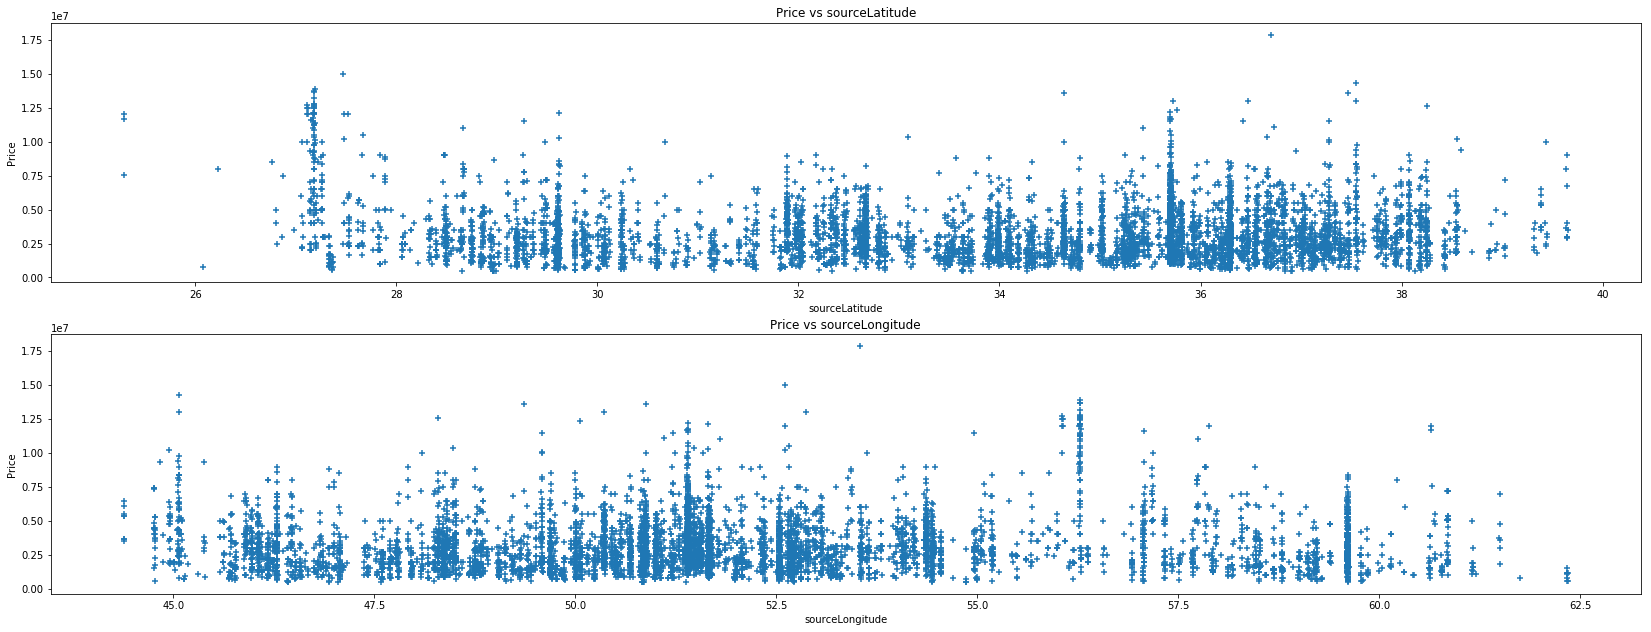

In [24]:
fig1, (ay1, ay2) = plt.subplots(2, 1)


ay1.scatter(x = X_train['sourceLatitude'], y = y_train, marker = "+")
ay1.set_title('Price vs sourceLatitude')
ay1.set_xlabel('sourceLatitude')
ay1.set_ylabel('Price')

ay2.scatter(x = X_train['sourceLongitude'], y = y_train, marker = "+")
ay2.set_title('Price vs sourceLongitude')
ay2.set_xlabel('sourceLongitude')
ay2.set_ylabel('Price')

fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/sourceEffects.png", dpi=100)
plt.show()

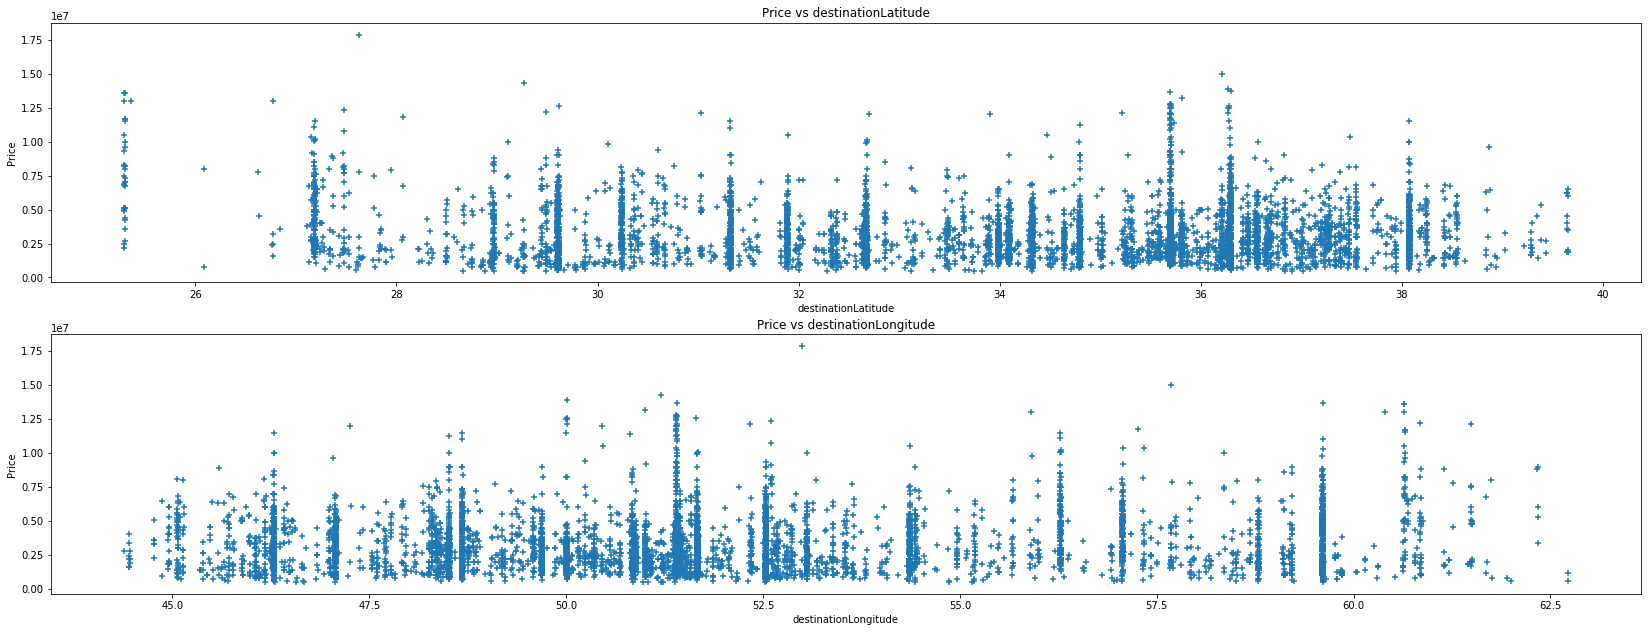

In [25]:
fig2, (ay3, ay4) = plt.subplots(2, 1)


ay3.scatter(x = X_train['destinationLatitude'], y = y_train, marker = "+")
ay3.set_title('Price vs destinationLatitude')
ay3.set_xlabel('destinationLatitude')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['destinationLongitude'], y = y_train, marker = "+")
ay4.set_title('Price vs destinationLongitude')
ay4.set_xlabel('destinationLongitude')
ay4.set_ylabel('Price')

fig2.set_size_inches(28.5, 10.5)
fig2.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/destinationEffects.png", dpi=100)
plt.show()

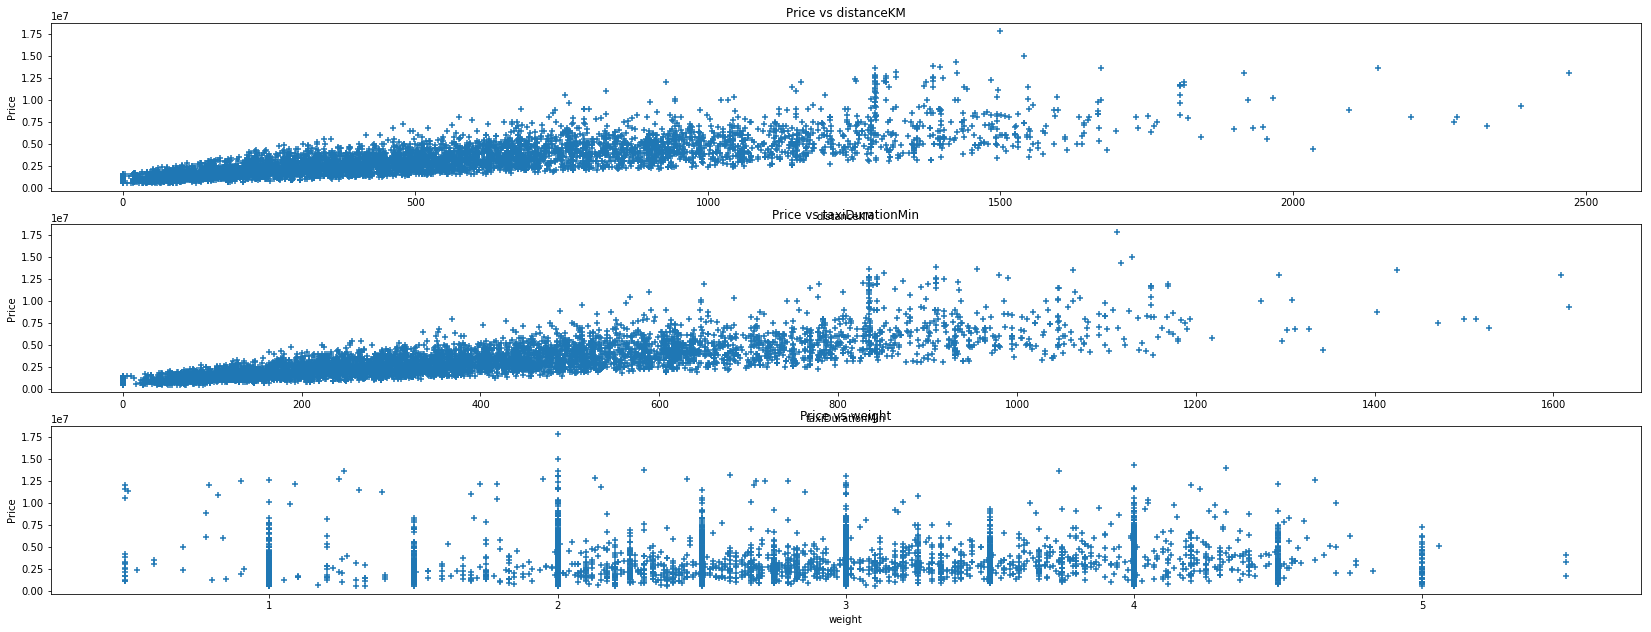

In [26]:
fig3, (ay3, ay4, ay5) = plt.subplots(3, 1)


ay3.scatter(x = X_train['distanceKM'], y = y_train, marker = "+")
ay3.set_title('Price vs distanceKM')
ay3.set_xlabel('distanceKM')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['taxiDurationMin'], y = y_train, marker = "+")
ay4.set_title('Price vs taxiDurationMin')
ay4.set_xlabel('taxiDurationMin')
ay4.set_ylabel('Price')

ay5.scatter(x = X_train['weight'], y = y_train, marker = "+")
ay5.set_title('Price vs weight')
ay5.set_xlabel('weight')
ay5.set_ylabel('Price')

fig3.set_size_inches(28.5, 10.5)
fig3.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/distance-time-Effects.png", dpi=100)
plt.show()

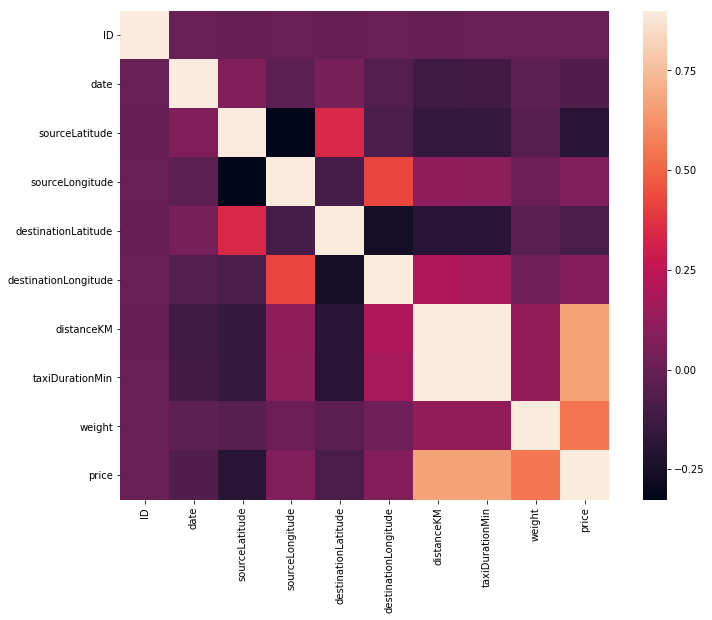

In [27]:
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)


 mu = 3050685.40 and sigma = 1834990.40



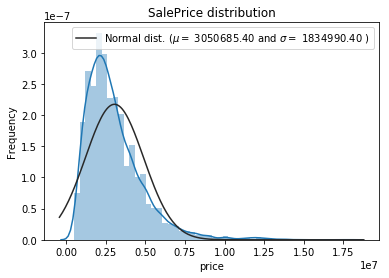

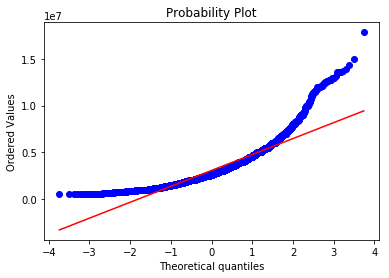

In [28]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 14.77 and sigma = 0.57



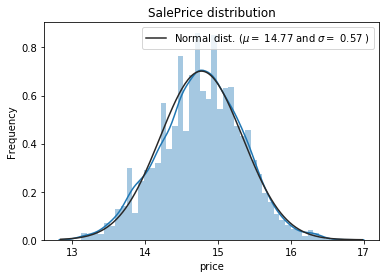

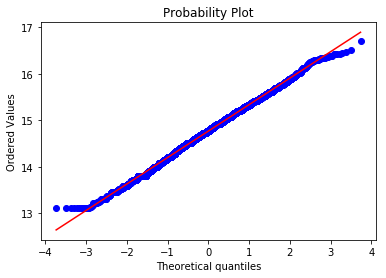

In [29]:
y_train_lp = np.log1p(y_train)

sns.distplot(y_train_lp, fit=norm);
(mu, sigma) = norm.fit(y_train_lp)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train_lp, plot=plt)
plt.show()

In [30]:
all_dates = data['date'].unique()
date_price_vec = []

for date in all_dates:
    date_price_vec.append(np.mean(data.query('date == ' + str(date) ).price))
    
states = all_data['SourceState_ids'].unique()
source_price_vec = []
destin_price_vec = []

for state in states:
    source_price_vec.append(np.mean(data.query('date == ' + str(state) ).price))
    destin_price_vec.append(np.mean(data.query('date == ' + str(state) ).price))

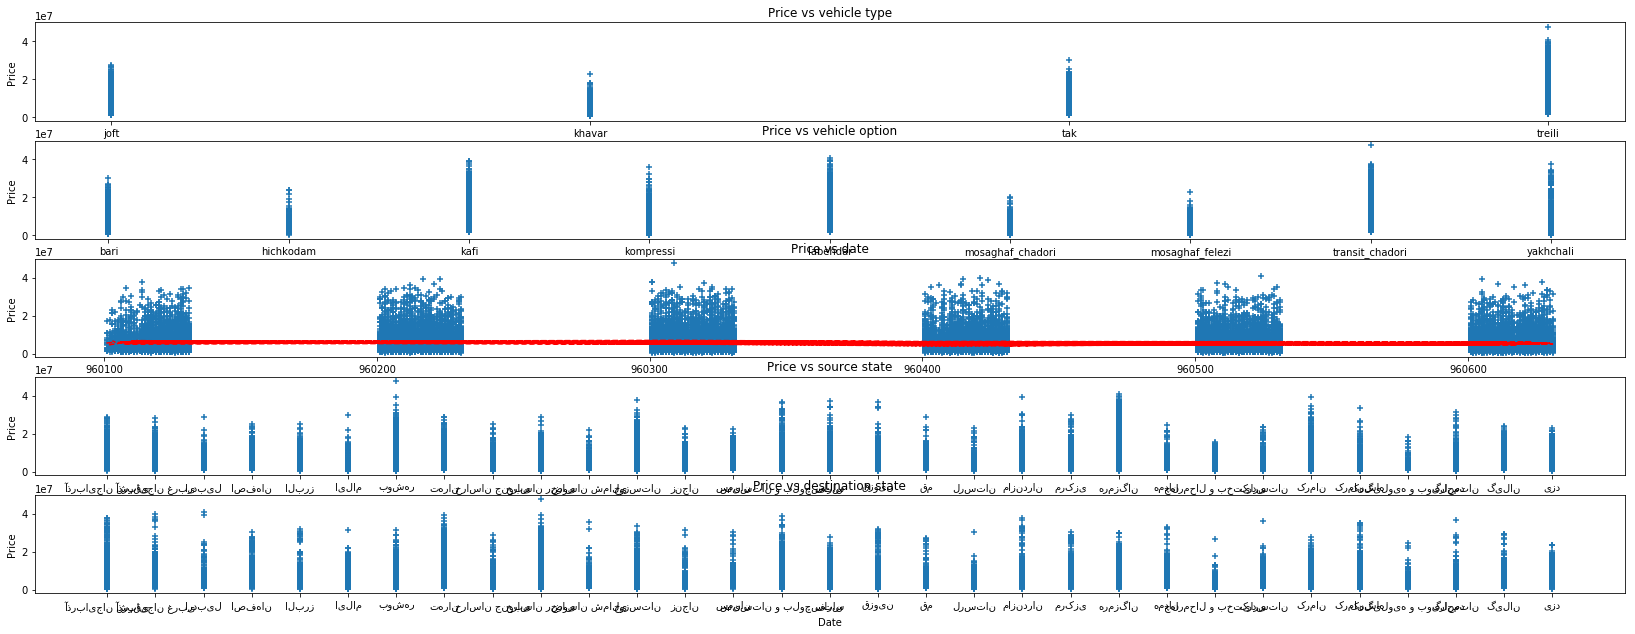

In [31]:
fig1, (ay1, ay2, ay3, ay4, ay5) = plt.subplots(5, 1)


ay1.scatter(data.vehicleType, data.price, marker = "+")
ay1.plot([0, 1, 2, 3], [np.mean(data.query('vehicleType == 0').price), np.mean(data.query('vehicleType == 1').price),
         np.mean(data.query('vehicleType == 2').price), np.mean(data.query('vehicleType == 3').price)], 'r--')

ay1.set_title('Price vs vehicle type')
ay1.set_xlabel('Vehicle Type')
ay1.set_ylabel('Price')


ay2.scatter(data.vehicleOption, data.price, marker = "+")
ay2.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], [np.mean(data.query('vehicleOption == 0').price), 
                                       np.mean(data.query('vehicleOption == 1').price),
                                       np.mean(data.query('vehicleOption == 2').price), 
                                       np.mean(data.query('vehicleOption == 3').price), 
                                       np.mean(data.query('vehicleOption == 4').price), 
                                       np.mean(data.query('vehicleOption == 5').price),
                                       np.mean(data.query('vehicleOption == 6').price),
                                       np.mean(data.query('vehicleOption == 7').price), 
                                       np.mean(data.query('vehicleOption == 8').price)], 'r--')


ay2.set_title('Price vs vehicle option')
ay2.set_xlabel('Vehicle Option')
ay2.set_ylabel('Price')

ay3.scatter(data.date, data.price, marker = "+")
ay3.plot(all_dates, date_price_vec, 'r--')
ay3.set_title('Price vs date')
ay3.set_xlabel('Date')
ay3.set_ylabel('Price')

ay4.scatter(data.SourceState, data.price, marker = "+")
ay4.plot(states, source_price_vec, 'r--')
ay4.set_title('Price vs source state')
ay4.set_xlabel('Date')
ay4.set_ylabel('Price')

ay5.scatter(data.destinationState, data.price, marker = "+")
ay5.plot(states, destin_price_vec, 'r--')
ay5.set_title('Price vs destination state')
ay5.set_xlabel('Date')
ay5.set_ylabel('Price')

fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/categoryEffects.png", dpi=100)
plt.show()